In [22]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import missingno as msno
import shapely.io
from shapely.geometry import Point, LineString

from lxml import etree
from datetime import time

# Load GTFS data

https://github.com/matsim-org/matsim-libs/tree/master/examples/scenarios/pt-tutorial

In [23]:
gtfs_name = 'gtfs_vigo'

## Shapes

In [24]:
shapes_filename = f'data/redes/bus/{gtfs_name}/shapes.txt'

shapes = pd.read_csv(shapes_filename)
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,Route_1,42.220991,-8.732931,1,8
1,Route_1,42.220970,-8.733023,2,16
2,Route_1,42.221896,-8.733792,3,137
3,Route_1,42.222359,-8.734177,4,197
4,Route_1,42.223174,-8.734853,5,304
...,...,...,...,...,...
135386,Route_1125,42.209217,-8.745284,135387,2886
135387,Route_1125,42.209170,-8.745577,135388,2910
135388,Route_1125,42.209102,-8.745828,135389,2932
135389,Route_1125,42.209061,-8.745965,135390,2945


In [25]:
shapes['geometry'] = shapes.apply(lambda row: Point(row['shape_pt_lon'], row['shape_pt_lat']), axis='columns')
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,Route_1,42.220991,-8.732931,1,8,POINT (-8.73293066783702 42.2209907703088)
1,Route_1,42.220970,-8.733023,2,16,POINT (-8.73302265022033 42.2209703914058)
2,Route_1,42.221896,-8.733792,3,137,POINT (-8.73379151366068 42.2218957554091)
3,Route_1,42.222359,-8.734177,4,197,POINT (-8.73417658165955 42.2223591910967)
4,Route_1,42.223174,-8.734853,5,304,POINT (-8.73485326084759 42.2231735660858)
...,...,...,...,...,...,...
135386,Route_1125,42.209217,-8.745284,135387,2886,POINT (-8.7452843763605 42.2092169251104)
135387,Route_1125,42.209170,-8.745577,135388,2910,POINT (-8.74557740769538 42.2091702378171)
135388,Route_1125,42.209102,-8.745828,135389,2932,POINT (-8.74582752368602 42.2091016967213)
135389,Route_1125,42.209061,-8.745965,135390,2945,POINT (-8.7459653211919 42.2090614955487)


In [26]:
edges = shapes.groupby('shape_id')['geometry'].apply(lambda x: LineString(x.to_list()))
edges = gpd.GeoDataFrame(edges, geometry='geometry')
edges = edges.set_crs('EPSG:4326')
edges

,geometry
shape_id,
Route_1,"LINESTRING (-8.73293 42.22099, -8.73302 42.220..."
Route_1001,"LINESTRING (-8.63285 42.22599, -8.63284 42.226..."
Route_1002,"LINESTRING (-8.63285 42.22599, -8.63284 42.226..."
Route_1003,"LINESTRING (-8.63285 42.22599, -8.63284 42.226..."
Route_1004,"LINESTRING (-8.71313 42.23884, -8.71392 42.238..."
...,...
Route_943,"LINESTRING (-8.76191 42.17954, -8.76197 42.179..."
Route_944,"LINESTRING (-8.7532 42.19999, -8.75326 42.2000..."
Route_993,"LINESTRING (-8.71436 42.19104, -8.71457 42.191..."


<Axes: >

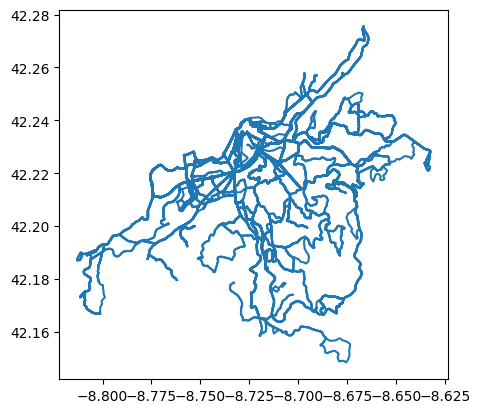

In [27]:
edges.plot()

In [28]:
if not os.path.exists('data/redes/bus/emt_shp/'):
    os.mkdir('data/redes/bus/emt_shp/')

edges.to_file('data/redes/bus/emt_shp/emt_edges.shp', driver='ESRI Shapefile')

## Stops

In [29]:
stops_filename = f'data/redes/bus/{gtfs_name}/stops.txt'

stops = pd.read_csv(stops_filename)
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,3493,P006930,Praza de América 1,Parada,42.220997,-8.732835,NaN,NaN,NaN,NaN,Europe/Madrid,1
1,3112,P003250,Rúa da Coruña 26,Parada,42.222379,-8.734134,NaN,NaN,NaN,NaN,Europe/Madrid,1
2,3498,P006970,Rúa da Coruña 52,Parada,42.223782,-8.735259,NaN,NaN,NaN,NaN,Europe/Madrid,1
3,4049,P0014892,Rúa do Conde de Torrecedeira 123,Parada,42.224929,-8.735414,NaN,NaN,NaN,NaN,Europe/Madrid,1
4,3658,P008460,Rúa do Conde de Torrecedeira 105,Parada,42.227500,-8.734097,NaN,NaN,NaN,NaN,Europe/Madrid,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,3437,P006415,Parque de Castrelos (Museo),Parada,42.213852,-8.727323,NaN,NaN,NaN,NaN,Europe/Madrid,1
1169,5414,PA20145,Samil por Bouzas,Parada,42.215944,-8.774726,NaN,NaN,NaN,NaN,Europe/Madrid,1
1170,5413,PA20144,Samil por Coia,Parada,42.215904,-8.774725,NaN,NaN,NaN,NaN,Europe/Madrid,1
1171,5377,PA20137,Camiño da Devesa (Asociación Veciños),Parada,42.246563,-8.669396,NaN,NaN,NaN,NaN,Europe/Madrid,1


In [30]:
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis='columns')

<Axes: >

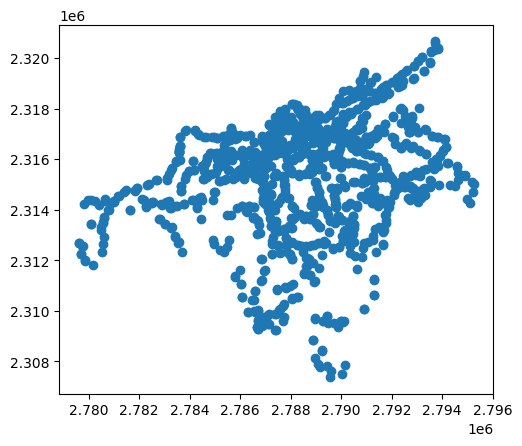

In [31]:
stops = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')
stops = stops.to_crs('EPSG:3035')
stops.plot()

In [32]:
# if not os.path.exists('data/redes/bus/emt_shp/'):
#     os.mkdir('data/redes/bus/emt_shp/')
# 
# stops.to_file('data/redes/bus/emt_shp/emt_nodes.shp', driver='ESRI Shapefile')

In [33]:
stops.loc[stops['stop_id'].isin([1380, 1381])]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,geometry


## Routes

In [34]:
routes_filename = f'data/redes/bus/{gtfs_name}/routes.txt'

routes = pd.read_csv(routes_filename)
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,1,C1,CIRCULAR CENTRO,NaN,3,NaN,ED4713,0
1,6,1,6,HOSP. ALVARO CUNQUEIRO - BEADE – PZA. ESPAÑA,NaN,3,NaN,CC3399,0
2,7,1,7,PZA. ESPAÑA – GARRIDA / ZAMÁNS / SOBREIRA,NaN,3,NaN,96DC99,0
3,8,1,A,ARENAL – PORTO / UNIVERSIDAD,NaN,3,NaN,77298F,0
4,10,1,10,TEIS – CANIDO – SAIÁNS,NaN,3,NaN,993300,0
5,11,1,11,SAN MIGUEL - CABRAL,NaN,3,NaN,E20026,0
6,13,1,13,TEIXUGUEIRAS – HOSP. MEIXOEIRO,NaN,3,NaN,00B0F0,0
7,14,1,14,CHANS – GRAN VÍA,NaN,3,NaN,818E7E,0
8,16,1,16,COIA – ESTACIÓN FF.CC. (GUIXAR),NaN,3,NaN,818E7E,0
9,17,1,17,MATAMÁ (BALSA) – A GUÍA / RÍOS,NaN,3,NaN,D6F51F,0


## Trips

In [35]:
trips_filename = f'data/redes/bus/{gtfs_name}/trips.txt'

trips = pd.read_csv(trips_filename)
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible
0,1,C1 01LP100_001001,C1 01LP100_001001_2,PRAZA AMÉRICA,0,NaN,Route_1,1
1,1,C1 01LP100_001001,C1 01LP100_001001_3,PRAZA AMÉRICA,0,NaN,Route_1,1
2,1,C1 01LP100_001001,C1 01LP100_001001_4,PRAZA AMÉRICA,0,NaN,Route_1,1
3,1,C1 01LP100_001001,C1 01LP100_001001_5,PRAZA AMÉRICA,0,NaN,Route_1,1
4,1,C1 01LP100_001001,C1 01LP100_001001_6,PRAZA AMÉRICA,0,NaN,Route_1,1
...,...,...,...,...,...,...,...,...
3698,23,L2301LP501_023001,L2301LP501_023001_24,BALAIDOS - M. ECHEGARAY,1,NaN,Route_167,1
3699,23,L2301LP501_023001,L2301LP501_023001_25,GREGORIO ESPINO,0,NaN,Route_166,1
3700,23,L2301LP501_023001,L2301LP501_023001_26,BALAIDOS - M. ECHEGARAY,1,NaN,Route_167,1
3701,23,L2301LP501_023001,L2301LP501_023001_27,GREGORIO ESPINO,0,NaN,Route_166,1


In [36]:
trips.loc[trips['trip_id'].eq('968D0V53')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible


In [37]:
trips['trip_id'].nunique()

3703

## Frequencies

In [38]:
frequencies_filename = f'data/redes/bus/{gtfs_name}/frequencies.txt'

has_frequencies = False

try:
    frequencies = pd.read_csv(frequencies_filename)
    has_frequencies = True
except:
    print('Frequencies file not found')

Frequencies file not found


In [39]:
if has_frequency:
    frequencies['start_time'] = frequencies['start_time'].astype('timedelta64[s]')
    frequencies['end_time'] = frequencies['end_time'].astype('timedelta64[s]')

## Stop times

In [40]:
stop_times_filename = f'data/redes/bus/{gtfs_name}/stop_times.txt'

stop_times = pd.read_csv(stop_times_filename)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,C1 01LP100_001001_2,07:32:00,07:32:00,3493,1,NaN,0,0,0
1,C1 01LP100_001001_2,07:33:02,07:33:02,3112,2,NaN,0,0,197
2,C1 01LP100_001001_2,07:34:00,07:34:00,3498,3,NaN,0,0,379
3,C1 01LP100_001001_2,07:34:37,07:34:37,4049,4,NaN,0,0,525
4,C1 01LP100_001001_2,07:35:54,07:35:54,3658,5,NaN,0,0,831
...,...,...,...,...,...,...,...,...,...
135808,L2301LP501_023001_28,21:15:22,21:15:22,3337,16,NaN,0,0,4600
135809,L2301LP501_023001_28,21:16:04,21:16:04,3504,17,NaN,0,0,4738
135810,L2301LP501_023001_28,21:17:53,21:17:53,3412,18,NaN,0,0,5091
135811,L2301LP501_023001_28,21:19:09,21:19:09,4057,19,NaN,0,0,5338


In [41]:
# assuming only on departure time
stop_times_departures = stop_times.groupby('trip_id')[['arrival_time', 'departure_time']].first().reset_index()

In [42]:
# convert arrivals and departures to timedelta (what happens when we go over 1 day?)
stop_times_departures['arrival_time'] = stop_times_departures['arrival_time'].astype('timedelta64[s]')
stop_times_departures['departure_time'] = stop_times_departures['departure_time'].astype('timedelta64[s]')


stop_times_departures = stop_times_departures.rename(columns={'arrival_time': 'arrival_time_original'})
stop_times_departures = stop_times_departures.rename(columns={'departure_time': 'departure_time_original'})
stop_times_departures

,trip_id,arrival_time_original,departure_time_original
0,20101L0113_201001_10,0 days 13:32:00,0 days 13:32:00
1,20101L0113_201001_11,0 days 14:02:00,0 days 14:02:00
2,20101L0113_201001_12,0 days 14:41:00,0 days 14:41:00
3,20101L0113_201001_13,0 days 15:10:00,0 days 15:10:00
4,20101L0113_201001_14,0 days 16:02:00,0 days 16:02:00
...,...,...,...
3698,TU201LV 08_500001_3,0 days 12:00:00,0 days 12:00:00
3699,TU201LV 08_500001_4,0 days 16:30:00,0 days 16:30:00
3700,TU201LV 08_500001_5,0 days 18:30:00,0 days 18:30:00
3701,U1 07LV 01_201007_2,0 days 08:30:00,0 days 08:30:00


In [43]:
# merging stop_times with stop_times_departures -> copies of first row arrival and departure times in front of every stop in the trip
stop_times_merged = stop_times.merge(stop_times_departures, on='trip_id', how='left')
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original
0,C1 01LP100_001001_2,07:32:00,07:32:00,3493,1,NaN,0,0,0,0 days 07:32:00,0 days 07:32:00
1,C1 01LP100_001001_2,07:33:02,07:33:02,3112,2,NaN,0,0,197,0 days 07:32:00,0 days 07:32:00
2,C1 01LP100_001001_2,07:34:00,07:34:00,3498,3,NaN,0,0,379,0 days 07:32:00,0 days 07:32:00
3,C1 01LP100_001001_2,07:34:37,07:34:37,4049,4,NaN,0,0,525,0 days 07:32:00,0 days 07:32:00
4,C1 01LP100_001001_2,07:35:54,07:35:54,3658,5,NaN,0,0,831,0 days 07:32:00,0 days 07:32:00
...,...,...,...,...,...,...,...,...,...,...,...
135808,L2301LP501_023001_28,21:15:22,21:15:22,3337,16,NaN,0,0,4600,0 days 20:52:00,0 days 20:52:00
135809,L2301LP501_023001_28,21:16:04,21:16:04,3504,17,NaN,0,0,4738,0 days 20:52:00,0 days 20:52:00
135810,L2301LP501_023001_28,21:17:53,21:17:53,3412,18,NaN,0,0,5091,0 days 20:52:00,0 days 20:52:00
135811,L2301LP501_023001_28,21:19:09,21:19:09,4057,19,NaN,0,0,5338,0 days 20:52:00,0 days 20:52:00


In [44]:
# adding a boolean flag if the trip is in frequencies.txt
# stop_times_merged['is_relative'] = stop_times_merged['trip_id'].isin(frequencies['trip_id'])
stop_times_merged['is_relative'] = False
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative
0,C1 01LP100_001001_2,07:32:00,07:32:00,3493,1,NaN,0,0,0,0 days 07:32:00,0 days 07:32:00,False
1,C1 01LP100_001001_2,07:33:02,07:33:02,3112,2,NaN,0,0,197,0 days 07:32:00,0 days 07:32:00,False
2,C1 01LP100_001001_2,07:34:00,07:34:00,3498,3,NaN,0,0,379,0 days 07:32:00,0 days 07:32:00,False
3,C1 01LP100_001001_2,07:34:37,07:34:37,4049,4,NaN,0,0,525,0 days 07:32:00,0 days 07:32:00,False
4,C1 01LP100_001001_2,07:35:54,07:35:54,3658,5,NaN,0,0,831,0 days 07:32:00,0 days 07:32:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
135808,L2301LP501_023001_28,21:15:22,21:15:22,3337,16,NaN,0,0,4600,0 days 20:52:00,0 days 20:52:00,False
135809,L2301LP501_023001_28,21:16:04,21:16:04,3504,17,NaN,0,0,4738,0 days 20:52:00,0 days 20:52:00,False
135810,L2301LP501_023001_28,21:17:53,21:17:53,3412,18,NaN,0,0,5091,0 days 20:52:00,0 days 20:52:00,False
135811,L2301LP501_023001_28,21:19:09,21:19:09,4057,19,NaN,0,0,5338,0 days 20:52:00,0 days 20:52:00,False


In [45]:
# define a helper function for timestamp to str conversion
def timedelta_to_str(timedelta):
    return f"{int(timedelta.total_seconds() // 3600):02}:{int((timedelta.total_seconds() % 3600) // 60):02}:{int(timedelta.total_seconds() % 60):02}"

In [82]:
# substracting first row arrival time from arrival times of all stops -> relative arrivals
stop_times_merged['arrival_time_offset'] = stop_times_merged['arrival_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time_original']
# substracting first row arrival time from departure times of all stops -> relative departures
stop_times_merged['departure_time_offset'] = stop_times_merged['arrival_time_offset'] + stop_times_merged['departure_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time'].astype('timedelta64[s]') #+ pd.to_timedelta('00:00:10')

# get string representations for MATSim
stop_times_merged['arrival_time_offset_str'] = stop_times_merged['arrival_time_offset'].apply(lambda x: timedelta_to_str(x))
stop_times_merged['departure_time_offset_str'] = stop_times_merged['departure_time_offset'].apply(lambda x: timedelta_to_str(x))

stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative,arrival_time_offset,departure_time_offset,arrival_time_offset_str,departure_time_offset_str
0,C1 01LP100_001001_2,07:32:00,07:32:00,3493,1,NaN,0,0,0,0 days 07:32:00,0 days 07:32:00,False,0 days 00:00:00,0 days 00:00:00,00:00:00,00:00:00
1,C1 01LP100_001001_2,07:33:02,07:33:02,3112,2,NaN,0,0,197,0 days 07:32:00,0 days 07:32:00,False,0 days 00:01:02,0 days 00:01:02,00:01:02,00:01:02
2,C1 01LP100_001001_2,07:34:00,07:34:00,3498,3,NaN,0,0,379,0 days 07:32:00,0 days 07:32:00,False,0 days 00:02:00,0 days 00:02:00,00:02:00,00:02:00
3,C1 01LP100_001001_2,07:34:37,07:34:37,4049,4,NaN,0,0,525,0 days 07:32:00,0 days 07:32:00,False,0 days 00:02:37,0 days 00:02:37,00:02:37,00:02:37
4,C1 01LP100_001001_2,07:35:54,07:35:54,3658,5,NaN,0,0,831,0 days 07:32:00,0 days 07:32:00,False,0 days 00:03:54,0 days 00:03:54,00:03:54,00:03:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135808,L2301LP501_023001_28,21:15:22,21:15:22,3337,16,NaN,0,0,4600,0 days 20:52:00,0 days 20:52:00,False,0 days 00:23:22,0 days 00:23:22,00:23:22,00:23:22
135809,L2301LP501_023001_28,21:16:04,21:16:04,3504,17,NaN,0,0,4738,0 days 20:52:00,0 days 20:52:00,False,0 days 00:24:04,0 days 00:24:04,00:24:04,00:24:04
135810,L2301LP501_023001_28,21:17:53,21:17:53,3412,18,NaN,0,0,5091,0 days 20:52:00,0 days 20:52:00,False,0 days 00:25:53,0 days 00:25:53,00:25:53,00:25:53
135811,L2301LP501_023001_28,21:19:09,21:19:09,4057,19,NaN,0,0,5338,0 days 20:52:00,0 days 20:52:00,False,0 days 00:27:09,0 days 00:27:09,00:27:09,00:27:09


## Calendar

In [47]:
calendar_filename = f'data/redes/bus/{gtfs_name}/calendar.txt'

if os.path.exists(calendar_filename):
    has_calendar = pd.read_csv(calendar_filename).shape[0] > 0
else:
    has_calendar = False

if has_calendar:
    calendar = pd.read_csv(calendar_filename, parse_dates=['start_date', 'end_date'])
    print(calendar)
else:
    print(f'There is no calendar file or it\'s empty')

There is no calendar file or it's empty


## Calendar dates

In [48]:
calendar_dates_filename = f'data/redes/bus/{gtfs_name}/calendar_dates.txt'

if os.path.exists(calendar_dates_filename):
    has_calendar_dates = pd.read_csv(calendar_dates_filename).shape[0] > 0
else:
    has_calendar_dates = False

if has_calendar_dates:
    calendar_dates = pd.read_csv(calendar_dates_filename, parse_dates=['date'])
    print(calendar_dates)
else:
    print(f'There is no calendar dates file or it\'s empty')


            service_id       date  exception_type
0    20101L0113_201001 2025-03-06               1
1    20101L0113_201001 2025-03-07               1
2    20101L0113_201001 2025-03-10               1
3    20101L0113_201001 2025-03-11               1
4    20101L0113_201001 2025-03-12               1
..                 ...        ...             ...
668  U1 07LV 01_201007 2025-03-06               1
669  U1 07LV 01_201007 2025-03-07               1
670  U1 07LV 01_201007 2025-03-10               1
671  U1 07LV 01_201007 2025-03-11               1
672  U1 07LV 01_201007 2025-03-12               1

[673 rows x 3 columns]


# Prepare MATSim configs

## Create nodes

Nodes are created from `stops.txt` geometry column

In [131]:
# map trips to stops
trips_to_stops = stop_times.groupby('trip_id')['stop_id'].apply(pd.Series.to_list)
trips_to_stops

trip_id
20101L0113_201001_10    [3353, 3331, 3333, 3337, 2922, 2923, 4960, 496...
20101L0113_201001_11    [3684, 3680, 3728, 3678, 3679, 3682, 3687, 297...
20101L0113_201001_12    [3354, 2985, 2979, 2982, 2981, 3265, 3266, 327...
20101L0113_201001_13    [3684, 3680, 3728, 3678, 3679, 3682, 3687, 317...
20101L0113_201001_14    [3353, 3331, 3333, 3337, 2922, 2923, 4960, 544...
                                              ...                        
TU201LV 08_500001_3                        [5519, 3358, 3425, 3437, 2997]
TU201LV 08_500001_4                        [5519, 3358, 3425, 3437, 2997]
TU201LV 08_500001_5                        [5519, 3358, 3425, 3437, 2997]
U1 07LV 01_201007_2     [3331, 3333, 3337, 2922, 2923, 4960, 4963, 400...
U1 07LV 01_201007_3     [3684, 3680, 3728, 3678, 3679, 3682, 3687, 317...
Name: stop_id, Length: 3703, dtype: object

In [132]:
trips_to_stops = trips_to_stops.to_frame().join(trips.set_index('trip_id').loc[:, ['shape_id']], how='left')
trips_to_stops

,stop_id,shape_id
trip_id,,
20101L0113_201001_10,"[3353, 3331, 3333, 3337, 2922, 2923, 4960, 496...",Route_335
20101L0113_201001_11,"[3684, 3680, 3728, 3678, 3679, 3682, 3687, 297...",Route_340
20101L0113_201001_12,"[3354, 2985, 2979, 2982, 2981, 3265, 3266, 327...",Route_339
20101L0113_201001_13,"[3684, 3680, 3728, 3678, 3679, 3682, 3687, 317...",Route_336
20101L0113_201001_14,"[3353, 3331, 3333, 3337, 2922, 2923, 4960, 544...",Route_372
...,...,...
TU201LV 08_500001_3,"[5519, 3358, 3425, 3437, 2997]",Route_777
TU201LV 08_500001_4,"[5519, 3358, 3425, 3437, 2997]",Route_777
TU201LV 08_500001_5,"[5519, 3358, 3425, 3437, 2997]",Route_777


In [133]:
shapes_to_stops = trips_to_stops.groupby('shape_id').first()
shapes_to_stops = shapes_to_stops.explode('stop_id')
shapes_to_stops

,stop_id
shape_id,
Route_1,3493
Route_1,3112
Route_1,3498
Route_1,4049
Route_1,3658
...,...
Route_999,4963
Route_999,4852
Route_999,3279


In [134]:
shapes_to_stops.loc[:, 'repeat'] = shapes_to_stops.groupby(['shape_id', 'stop_id']).cumcount().rename('repeat')
shapes_to_stops

,stop_id,repeat
shape_id,,
Route_1,3493,0
Route_1,3112,0
Route_1,3498,0
Route_1,4049,0
Route_1,3658,0
...,...,...
Route_999,4963,0
Route_999,4852,0
Route_999,3279,0


In [182]:
trips_to_stops.loc[trips_to_stops['shape_id'].eq('Route_465')]

,stop_id,shape_id
trip_id,,
H 01FP102_101001_13,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01FP102_101001_17,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01FP102_101001_21,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01FP102_101001_25,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01FP102_101001_27,"[3452, 3673, 3372, 3373, 3415, 3763, 3093, 279...",Route_465
H 01FP102_101001_5,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01FP102_101001_9,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01LP200_101001_13,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465
H 01LP200_101001_19,"[3451, 5473, 3452, 3673, 3372, 3373, 3415, 376...",Route_465


In [181]:
shapes_to_stops.loc['Route_465']

,stop_id,repeat
shape_id,,
Route_465,3451,0
Route_465,5473,0
Route_465,3452,0
Route_465,3673,0
Route_465,3372,0
Route_465,3373,0
Route_465,3415,0
Route_465,3763,0
Route_465,3093,0


In [135]:
nodes = pd.merge(shapes_to_stops.reset_index(), stops.loc[:, ['stop_id', 'stop_name', 'geometry']], on='stop_id', how='left')
nodes['node_id'] = nodes['shape_id'] + '_' + nodes['stop_id'].astype('str')
nodes

,shape_id,stop_id,repeat,stop_name,geometry,node_id
0,Route_1,3493,0,Praza de América 1,POINT (2787093.524 2316228.523),Route_1_3493
1,Route_1,3112,0,Rúa da Coruña 26,POINT (2787024.867 2316404.542),Route_1_3112
2,Route_1,3498,0,Rúa da Coruña 52,POINT (2786970.715 2316579.384),Route_1_3498
3,Route_1,4049,0,Rúa do Conde de Torrecedeira 123,POINT (2786987.561 2316706.694),Route_1_4049
4,Route_1,3658,0,Rúa do Conde de Torrecedeira 105,POINT (2787158.394 2316957.878),Route_1_3658
...,...,...,...,...,...,...
7733,Route_999,4963,0,Estrada Clara Campoamor (fronte Rotonda HAC),POINT (2787482.41 2312582.167),Route_999_4963
7734,Route_999,4852,0,H. A. Cunqueiro (Hospital de Día),POINT (2787566.732 2312275.065),Route_999_4852
7735,Route_999,3279,0,Estrada da Venda 238,POINT (2788042.304 2312041.602),Route_999_3279
7736,Route_999,3276,0,Estrada da Venda (cruce Camiño da Coutadiña),POINT (2788517.04 2311476.97),Route_999_3276


In [136]:
nodes = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:3035')

## Create edges



In [137]:
edges = nodes.copy()
edges = edges.rename(columns={'stop_id': 'from_node_id',
                              'geometry': 'from_geometry'})

# get consecutive nodes data on the same line
edges['to_node_id'] = edges.groupby('shape_id')['from_node_id'].shift(-1)
edges['to_geometry'] = edges.groupby('shape_id')['from_geometry'].shift(-1)
edges = edges.dropna()

# convert to line geometry
edges['geometry'] = edges.loc[:, ['from_geometry', 'to_geometry']].apply(lambda row: LineString([row['from_geometry'], row['to_geometry']]), axis='columns')

# drop unused columns  
edges = edges.drop(columns=['from_geometry', 'to_geometry', 'node_id', 'stop_name'])

# assign meaningful edge_id
edges['edge_id'] = edges['shape_id'] + '_' + edges['from_node_id'].astype('str') + '_' + edges['to_node_id'].astype('str')
edges['length'] = edges['geometry'].length

edges

,shape_id,from_node_id,repeat,to_node_id,geometry,edge_id,length
0,Route_1,3493,0,3112,"LINESTRING (2787093.524 2316228.523, 2787024.8...",Route_1_3493_3112,188.935944
1,Route_1,3112,0,3498,"LINESTRING (2787024.867 2316404.542, 2786970.7...",Route_1_3112_3498,183.035259
2,Route_1,3498,0,4049,"LINESTRING (2786970.715 2316579.384, 2786987.5...",Route_1_3498_4049,128.420464
3,Route_1,4049,0,3658,"LINESTRING (2786987.561 2316706.694, 2787158.3...",Route_1_4049_3658,303.771460
4,Route_1,3658,0,3660,"LINESTRING (2787158.394 2316957.878, 2787311.1...",Route_1_3658_3660,254.600109
...,...,...,...,...,...,...,...
7732,Route_999,5448,0,4963,"LINESTRING (2787150.936 2314233.869, 2787482.4...",Route_999_5448_4963,1684.634997
7733,Route_999,4963,0,4852,"LINESTRING (2787482.41 2312582.167, 2787566.73...",Route_999_4963_4852,318.468217
7734,Route_999,4852,0,3279,"LINESTRING (2787566.732 2312275.065, 2788042.3...",Route_999_4852_3279,529.785852
7735,Route_999,3279,0,3276,"LINESTRING (2788042.304 2312041.602, 2788517.0...",Route_999_3279_3276,737.688120


In [138]:
edges = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:3035')

## Input date

The date introduced is used to generate transit schedules for this day in particular.

`calendat.txt` and `calendar_dates.txt` are checked to filter the schedule.

In [139]:
date_to_check = pd.to_datetime('2025-03-10')

weekday_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [140]:
# if we have both files
if has_calendar & has_calendar_dates:
    
    # CHECK CALENDAR
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday]
    
    # CHECK CALENDAR DATES
    if relevant_service_ids.shape[0] > 0:
        if date_to_check in calendar_dates['date'].values:
            service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
            service_ids_to_delete = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(2), 'service_id']
            
            # adding service ids
            relevant_service_ids = pd.concat([relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_add), :]], axis='index')
            print(f'Added: {service_ids_to_add}')
            
            # removing service ids
            relevant_service_ids_merged = pd.merge(relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_delete), :], how='left', indicator=True)
            relevant_service_ids = relevant_service_ids_merged.loc[relevant_service_ids_merged['_merge'].ne('both')].drop(columns='_merge')
            print(f'Deleted: {service_ids_to_delete}')
        else:
            print('No changes were made to the candidate list.')
    else:
        if date_to_check in calendar_dates['date'].values:
            if calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), :].shape[0] > 0:
                pass # add exception
        else:
            print('No service_id found for this date.')
# if we have calendar only
elif has_calendar & (not has_calendar_dates):
    # define conditions to filter calendars 
    condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
    condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)
    
    # preliminarly filter by conditions
    relevant_service_ids = calendar.loc[condition_date_range & condition_weekday]
# if we have calendar_dates only
else:
    relevant_service_ids = []
    
    if date_to_check in calendar_dates['date'].values:
        service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
        
        # adding service ids
        relevant_service_ids = service_ids_to_add
        print(f'Added: {service_ids_to_add}')


Added: 2      20101L0113_201001
7      20102L0120_201002
12     20103L0113_201003
17     20104L0114_201004
22     20105L0114_201005
             ...        
652    REF03LP105_150003
657    RES02L0100_004901
658    RES02L0100_013201
664    RES05L0100_400005
670    U1 07LV 01_201007
Name: service_id, Length: 110, dtype: object


In [141]:
relevant_service_ids

2      20101L0113_201001
7      20102L0120_201002
12     20103L0113_201003
17     20104L0114_201004
22     20105L0114_201005
             ...        
652    REF03LP105_150003
657    RES02L0100_004901
658    RES02L0100_013201
664    RES05L0100_400005
670    U1 07LV 01_201007
Name: service_id, Length: 110, dtype: object

## Network to XML (`network.xml`)

In [142]:
# filter nodes and shapes for relevant shape_id values only
shape_id_to_use = trips.loc[trips['service_id'].isin(relevant_service_ids), 'shape_id']

nodes_filtered = nodes.loc[nodes['shape_id'].isin(shape_id_to_use), :]
edges_filtered = edges.loc[edges['shape_id'].isin(shape_id_to_use), :]

nodes_filtered.shape, edges_filtered.shape

((6479, 6), (6299, 7))

In [143]:
version = 2
graph_to_load = 'v' + str(version)

In [144]:
root = etree.Element('network', name='vitrasa_network_' + graph_to_load)

## GENERATING NODES

nodes_item = etree.SubElement(root, 'nodes')

for _, node in nodes_filtered.iterrows():
    
    node_id = str(node['node_id'])
    
    if node['repeat'] == 0:
        nodes_item.append(etree.Element('node', 
                                        id=node_id, 
                                        x=str(node['geometry'].coords.xy[0][0]), 
                                        y=str(node['geometry'].coords.xy[1][0])))


## GENERATING LINKS

links_item = etree.SubElement(root, 'links')

for _, link in edges_filtered.iterrows():

    from_node = link['shape_id'] + '_' + str(link['from_node_id'])
    to_node = link['shape_id'] + '_' + str(link['to_node_id'])
    
    link_item = etree.SubElement(links_item, 'link')

    link_item.set('id', link['edge_id'])
    link_item.set('from', str(from_node))
    link_item.set('to', str(to_node))
    link_item.set('freespeed', str(10))
    link_item.set('capacity', str(100))
    link_item.set('permlanes', str(1))
    link_item.set('length', str(link['length'] * 1000))


    link_item.set('modes', 'pt')

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

if not os.path.exists(os.path.join(os.getcwd(), 'networks_vitrasa')):
    os.mkdir(os.path.join(os.getcwd(), 'networks_vitrasa'))
    
with open('networks_vitrasa/network_' + graph_to_load + '.xml', 'wb') as file:
    file.write(final_xml)

In [145]:
# nodes.to_file('nodes_simplified.shp', driver='ESRI Shapefile')
# edges.to_file('edges_simplified.shp', driver='ESRI Shapefile')

## Map stops to edges



In [146]:
def duplicate_last_row(group):
    row_to_append = group.tail(1)
    row_to_append['from_node_id'] = row_to_append['to_node_id']
    
    return pd.concat([group, row_to_append], axis='index')

stops_to_edges = edges.groupby('shape_id')[['from_node_id', 'to_node_id', 'edge_id']].apply(duplicate_last_row)
stops_to_edges = stops_to_edges.reset_index()

stops_to_edges['stop_facility_id'] = 'SF_' + stops_to_edges['shape_id'] + '_' + stops_to_edges['from_node_id'].astype('str')
stops_to_edges = stops_to_edges.drop(columns=['to_node_id', 'level_1'])


stops_to_edges = pd.merge(stops_to_edges, stops.loc[:, ['stop_id', 'geometry']], left_on='from_node_id', right_on='stop_id', how='left')

# inverse column order
stops_to_edges = stops_to_edges[['stop_facility_id', 'edge_id', 'shape_id', 'geometry']]
stops_to_edges

,stop_facility_id,edge_id,shape_id,geometry
0,SF_Route_1_3493,Route_1_3493_3112,Route_1,POINT (2787093.524 2316228.523)
1,SF_Route_1_3112,Route_1_3112_3498,Route_1,POINT (2787024.867 2316404.542)
2,SF_Route_1_3498,Route_1_3498_4049,Route_1,POINT (2786970.715 2316579.384)
3,SF_Route_1_4049,Route_1_4049_3658,Route_1,POINT (2786987.561 2316706.694)
4,SF_Route_1_3658,Route_1_3658_3660,Route_1,POINT (2787158.394 2316957.878)
...,...,...,...,...
7733,SF_Route_999_4963,Route_999_4963_4852,Route_999,POINT (2787482.41 2312582.167)
7734,SF_Route_999_4852,Route_999_4852_3279,Route_999,POINT (2787566.732 2312275.065)
7735,SF_Route_999_3279,Route_999_3279_3276,Route_999,POINT (2788042.304 2312041.602)
7736,SF_Route_999_3276,Route_999_3276_3466,Route_999,POINT (2788517.04 2311476.97)


In [147]:
stops_to_edges.loc[:, 'repeat'] = stops_to_edges.groupby(['stop_facility_id', 'shape_id']).cumcount().rename('repeat')
stops_to_edges

,stop_facility_id,edge_id,shape_id,geometry,repeat
0,SF_Route_1_3493,Route_1_3493_3112,Route_1,POINT (2787093.524 2316228.523),0
1,SF_Route_1_3112,Route_1_3112_3498,Route_1,POINT (2787024.867 2316404.542),0
2,SF_Route_1_3498,Route_1_3498_4049,Route_1,POINT (2786970.715 2316579.384),0
3,SF_Route_1_4049,Route_1_4049_3658,Route_1,POINT (2786987.561 2316706.694),0
4,SF_Route_1_3658,Route_1_3658_3660,Route_1,POINT (2787158.394 2316957.878),0
...,...,...,...,...,...
7733,SF_Route_999_4963,Route_999_4963_4852,Route_999,POINT (2787482.41 2312582.167),0
7734,SF_Route_999_4852,Route_999_4852_3279,Route_999,POINT (2787566.732 2312275.065),0
7735,SF_Route_999_3279,Route_999_3279_3276,Route_999,POINT (2788042.304 2312041.602),0
7736,SF_Route_999_3276,Route_999_3276_3466,Route_999,POINT (2788517.04 2311476.97),0


In [172]:
stops_to_edges.loc[stops_to_edges['stop_facility_id'].eq('SF_Route_465_3179')]

,stop_facility_id,edge_id,shape_id,geometry,repeat


In [176]:
trips.loc[trips['shape_id'].eq('Route_465') & trips['service_id'].isin(relevant_service_ids)]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible
1343,6,L2701L0112_027001,L2701L0112_027001_18,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1452,6,H 01LP200_101001,H 01LP200_101001_7,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1458,6,H 01LP200_101001,H 01LP200_101001_13,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1464,6,H 01LP200_101001,H 01LP200_101001_19,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1468,6,H 01LP200_101001,H 01LP200_101001_23,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1480,6,H 02LP109_101002,H 02LP109_101002_13,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1486,6,H 02LP109_101002,H 02LP109_101002_19,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1507,6,H 03LP108_101003,H 03LP108_101003_19,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1527,6,H 04LP107_101004,H 04LP107_101004_18,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1
1566,6,H 06LP111_101006,H 06LP111_101006_14,HOSPITAL ALVARO CUNQUEIRO,0,NaN,Route_465,1


In [179]:
stop_times.loc[stop_times['trip_id'].eq('L2701L0112_027001_18')]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
52022,L2701L0112_027001_18,22:32:00,22:32:00,3452,1,Estrada do Porto (cruce Camiño do Frascuelo),0,0,530
52023,L2701L0112_027001_18,22:34:00,22:34:00,3673,2,Estrada do Porto (cruce Camiño do Frascuelo),0,0,847
52024,L2701L0112_027001_18,22:34:41,22:34:41,3372,3,Estrada do Porto (cruce Camiño do Frascuelo),0,0,1065
52025,L2701L0112_027001_18,22:35:16,22:35:16,3373,4,Estrada do Porto (cruce Camiño do Frascuelo),0,0,1245
52026,L2701L0112_027001_18,22:37:00,22:37:00,3415,5,Estrada do Porto (cruce Camiño do Frascuelo),0,0,1782
52027,L2701L0112_027001_18,22:37:14,22:37:14,3763,6,Estrada do Porto (cruce Camiño do Frascuelo),0,0,1900
52028,L2701L0112_027001_18,22:38:12,22:38:12,3093,7,Estrada do Porto (cruce Camiño do Frascuelo),0,0,2377
52029,L2701L0112_027001_18,22:38:44,22:38:44,2792,8,Estrada do Porto (cruce Camiño do Frascuelo),0,0,2637
52030,L2701L0112_027001_18,22:39:26,22:39:26,2795,9,Estrada do Porto (cruce Camiño do Frascuelo),0,0,2989
52031,L2701L0112_027001_18,22:40:17,22:40:17,2793,10,Estrada do Porto (cruce Camiño do Frascuelo),0,0,3404


## To XML (transitSchedule.xml)

In [166]:
# filter only relevant stops
stops_to_edges_filtered = stops_to_edges.loc[stops_to_edges['shape_id'].isin(shape_id_to_use)]

In [167]:
vehicle_counter = 0
is_block_id_present = False

In [168]:
root = etree.Element('transitSchedule')


transit_stops_item = etree.SubElement(root, 'transitStops')

# STOP FACILITIES
for _, stop_facility in stops_to_edges_filtered.iterrows():
    
    stop_facility_id = str(stop_facility['stop_facility_id'])
    
    if stop_facility['repeat'] == 0:    
        transit_stops_item.append(etree.Element('stopFacility', 
                                                id=stop_facility_id, 
                                                x=str(stop_facility['geometry'].coords.xy[1][0]), 
                                                y=str(stop_facility['geometry'].coords.xy[0][0]),
                                                linkRefId=str(stop_facility['edge_id'])
                                                ))
    
# transit_line_item = etree.SubElement(root, 'transitLine')

routes_filtered = routes.loc[routes['route_id'].isin(trips.loc[trips['shape_id'].isin(shape_id_to_use), 'route_id']), :]

# TRANSIT LINES
for _, route in routes_filtered.iterrows():
    
    transit_line_item = etree.SubElement(root, 'transitLine', 
                                          id=str(route['route_id']),
                                          name=str(route['route_short_name']))
    
    # TRANSIT ROUTE
    # filtering trips (transitRoute) for this route (transitLine) only
    trips_filtered = trips.loc[trips['route_id'].eq(route['route_id']) & trips['service_id'].isin(relevant_service_ids),:]
    
    for _, trip in trips_filtered.iterrows():
        
        transit_route_item = etree.SubElement(transit_line_item, 'transitRoute', 
                                              id=str(trip['trip_id']))
        
        # TRANSIT MODE
        transit_mode_item = etree.SubElement(transit_route_item, 'transportMode')
        transit_mode_item.text = "pt"
    
        routes_profile_item = etree.SubElement(transit_route_item, 'routeProfile')
        
        # ROUTE PROFILE
        # filtering stop_times for the current trip only
        stop_times_filtered = stop_times_merged.loc[stop_times_merged['trip_id'].eq(trip['trip_id']),:]
        
        is_first_stop = True
        last_stop_index = stop_times_filtered.tail(1).index
        for _, stop_time in stop_times_filtered.iterrows():
            
            stop_id = 'SF_' + trip['shape_id'] + '_' + str(stop_time['stop_id'])
            
            if is_first_stop:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     # arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
                is_first_stop = False
            elif _ == last_stop_index:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     # departureOffset=str(stop_time['departure_time_offset_str']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))
            else:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     awaitDeparture="true"
                                                     ))

        # ROUTE (all the links for a specific routes, not only the ones with stops)
        route_item = etree.SubElement(transit_route_item, 'route')
        
        edges_filtered = edges.loc[edges['shape_id'].eq(trip['shape_id']), :]
        
        for _, edge in edges_filtered.iterrows():
            route_item.append(etree.Element('link', 
                                            refId=edge['edge_id']))
        
        # DEPARTURES
        departures_item = etree.SubElement(transit_route_item, 'departures')
        
        # if there is a frequency for a trip, ...
        if has_frequencies:
            if trip['trip_id'] in frequencies['trip_id'].values:
                # print(f'Trip {trip['trip_id']} has a frequency')
                # ...generate a departure for every frequency
                
                # filtering frequencies for the current trip only
                frequencies_filtered = frequencies.loc[frequencies['trip_id'].eq(trip['trip_id']),:]
                
                for _, frequency in frequencies_filtered.iterrows(): # in every frequency there is an interval with it's frequency in seconds 
                    departures = pd.timedelta_range(start=frequency['start_time'], 
                                                    end=frequency['end_time'], 
                                                    freq=str(frequency['headway_secs']) + 's', 
                                                    closed='left')
                    
                    for departure_index, departure in enumerate(departures):
                        vehicle_counter = vehicle_counter + 1
    
                        if is_block_id_present:
                            vehicleRefId = str(trip['block_id'])
                        else:
                            vehicleRefId = 'veh_' + str(vehicle_counter)
    
                        departures_item.append(etree.Element('departure', 
                                                             id=str(_) + '_' + str(departure_index),
                                                             departureTime=timedelta_to_str(departure),
                                                             vehicleRefId=vehicleRefId
                                                             ))
        # if there is no frequency for a trip, ...
        else:
            vehicle_counter = vehicle_counter + 1
            
            if is_block_id_present:
                vehicleRefId = str(trip['block_id'])
            else:
                vehicleRefId = 'veh_' + str(vehicle_counter)

            # ...generate only one departure from stop_times_departures
            single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
            departures_item.append(etree.Element('departure', 
                                                     id=str(_),
                                                     departureTime=timedelta_to_str(single_departure),
                                                     vehicleRefId=vehicleRefId
                                                 ))


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)
    
with open('networks_vitrasa/transitSchedule.xml', 'wb') as file:
    file.write(final_xml)

In [171]:
routes_filtered

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,1,C1,CIRCULAR CENTRO,NaN,3,NaN,ED4713,0
1,6,1,6,HOSP. ALVARO CUNQUEIRO - BEADE – PZA. ESPAÑA,NaN,3,NaN,CC3399,0
2,7,1,7,PZA. ESPAÑA – GARRIDA / ZAMÁNS / SOBREIRA,NaN,3,NaN,96DC99,0
3,8,1,A,ARENAL – PORTO / UNIVERSIDAD,NaN,3,NaN,77298F,0
4,10,1,10,TEIS – CANIDO – SAIÁNS,NaN,3,NaN,993300,0
5,11,1,11,SAN MIGUEL - CABRAL,NaN,3,NaN,E20026,0
6,13,1,13,TEIXUGUEIRAS – HOSP. MEIXOEIRO,NaN,3,NaN,00B0F0,0
7,14,1,14,CHANS – GRAN VÍA,NaN,3,NaN,818E7E,0
8,16,1,16,COIA – ESTACIÓN FF.CC. (GUIXAR),NaN,3,NaN,818E7E,0
9,17,1,17,MATAMÁ (BALSA) – A GUÍA / RÍOS,NaN,3,NaN,D6F51F,0


## To XML (transitVehicles.xml)

In [169]:
# if 'block_id' is present in trips, ...
if is_block_id_present:
    # then generate a vehicle for every block_id
    vehicle_ids = trips['block_id'].unique()
else:
    # generate a vehicle for every departure/trip
    vehicle_ids = np.arange(1, vehicle_counter + 1)

vehicle_ids

array([   1,    2,    3, ..., 1793, 1794, 1795])

In [170]:
from lxml import etree

# Namespace and schema locations
namespace = "http://www.matsim.org/files/dtd"
schema_location = "http://www.matsim.org/files/dtd/vehicleDefinitions_v1.0.xsd"

# Namespace map
nsmap = {
    None: namespace,  # Default namespace
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

# Root element with namespaces
root = etree.Element("vehicleDefinitions", nsmap=nsmap)
root.set(etree.QName(nsmap["xsi"], "schemaLocation"), f"{namespace} {schema_location}")

# Vehicle type definition
vehicle_type = etree.SubElement(root, "vehicleType", id="bus")

description = etree.SubElement(vehicle_type, "description")
description.text = "Ordinary Bus"

capacity = etree.SubElement(vehicle_type, "capacity")
seats = etree.SubElement(capacity, "seats", persons="50")
standing = etree.SubElement(capacity, "standingRoom", persons="30")

length = etree.SubElement(vehicle_type, "length", meter="25.0")

# Adding vehicles
for vehicle_id in vehicle_ids:
    etree.SubElement(root, "vehicle", id='veh_' + str(vehicle_id), type='bus')

# Convert to pretty-printed XML string
xml_str = etree.tostring(root, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Save to file or print
with open("networks_vitrasa/vehicleDefinitions.xml", "wb") as f:
    f.write(xml_str)

## Create sample population

In [154]:
sample_population = pd.merge(stops[['stop_id', 'geometry']], stops[['stop_id', 'geometry']], how='cross', suffixes=['_origin', '_destination']).sample(100)
sample_population

,stop_id_origin,geometry_origin,stop_id_destination,geometry_destination
1177532,3815,POINT (2794632.48 2315180.898),3842,POINT (2791308.178 2315703.542)
250856,2924,POINT (2787049.441 2315902.882),3997,POINT (2793525.224 2314926.489)
957932,4074,POINT (2783569.686 2316289.61),3518,POINT (2787509.149 2313177.177)
1224534,3381,POINT (2787354.53 2313990.782),4039,POINT (2790138.62 2313204.756)
871643,3505,POINT (2788860.088 2315482.916),3655,POINT (2785454.448 2316674.815)
...,...,...,...,...
732747,3730,POINT (2792438.77 2319089.514),3735,POINT (2790511.664 2313410.951)
1222990,3306,POINT (2787493.808 2314266.31),3153,POINT (2790498.832 2313264.787)
660903,3557,POINT (2793105.264 2315342.611),3173,POINT (2788935.725 2311128.163)
652926,3526,POINT (2791427.224 2316100.175),3024,POINT (2789227.713 2314309.181)


In [155]:
sample_population['hour'] = pd.Series([np.random.uniform(4,9) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['minute'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['second'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population

,stop_id_origin,geometry_origin,stop_id_destination,geometry_destination,hour,minute,second
1177532,3815,POINT (2794632.48 2315180.898),3842,POINT (2791308.178 2315703.542),4,28,17
250856,2924,POINT (2787049.441 2315902.882),3997,POINT (2793525.224 2314926.489),6,15,31
957932,4074,POINT (2783569.686 2316289.61),3518,POINT (2787509.149 2313177.177),4,10,41
1224534,3381,POINT (2787354.53 2313990.782),4039,POINT (2790138.62 2313204.756),7,22,10
871643,3505,POINT (2788860.088 2315482.916),3655,POINT (2785454.448 2316674.815),7,56,33
...,...,...,...,...,...,...,...
732747,3730,POINT (2792438.77 2319089.514),3735,POINT (2790511.664 2313410.951),8,47,32
1222990,3306,POINT (2787493.808 2314266.31),3153,POINT (2790498.832 2313264.787),7,11,49
660903,3557,POINT (2793105.264 2315342.611),3173,POINT (2788935.725 2311128.163),8,51,3
652926,3526,POINT (2791427.224 2316100.175),3024,POINT (2789227.713 2314309.181),7,43,11


### Load distribution

In [156]:
distribution = pd.read_pickle('destination_stop_distribution.pkl')
distribution.head()

,Month,Weekday,Hour,Stop,Line,nearest_stops,proportion,cumsum
0,1,0,0,1040,30,1230,0.333333,0.333333
1,1,0,0,1040,30,8550,0.333333,0.666667
2,1,0,0,1040,30,14127,0.333333,1.000000
3,1,0,0,1260,30,5720,0.133333,0.133333
4,1,0,0,1260,30,8580,0.133333,0.266667


### Load demand

In [157]:
demand = pd.read_pickle('demand.pkl')
demand

Month  Weekday  Hour  Stop   Line
1      0        0     1040   30       3
                      1260   30      23
                             33      10
                      1280   30      23
                             33      22
                                     ..
12     6        23    20214  9        1
                             11      16
                             15       7
                             30       4
                      20215  5        1
Name: Card, Length: 2711102, dtype: int64

In [158]:
idx = pd.IndexSlice

demand.loc[idx[3,1,8,:,:]].sum()

np.int64(93476)

## To XML (population.xml)

In [159]:
root = etree.Element('plans')

for _, person in sample_population.iterrows():
    person_item = etree.SubElement(root, 'person')
    person_item.set('id', str(_))

    plan_item = etree.SubElement(person_item, 'plan')
    plan_item.set('selected', 'yes')

    
    origin_latitude = person['geometry_origin'].coords.xy[1][0]
    origin_longitude = person['geometry_origin'].coords.xy[0][0]
    destination_latitude = person['geometry_destination'].coords.xy[1][0]
    destination_longitude = person['geometry_destination'].coords.xy[0][0]
    
    origin_end_time = str(time(person['hour'], person['minute'], person['second']))
    destination_end_time = str(time(23,59,59))

    act_item_origin = etree.SubElement(plan_item, 'act')
    act_item_origin.set('type', 'h')
    act_item_origin.set('x', str(origin_longitude))
    act_item_origin.set('y', str(origin_latitude))
    act_item_origin.set('end_time', origin_end_time)

    leg_item = etree.SubElement(plan_item, 'leg')
    leg_item.set('mode', 'pt')

    act_item_destination = etree.SubElement(plan_item, 'act')
    act_item_destination.set('type', 'w')
    act_item_destination.set('x', str(destination_longitude))
    act_item_destination.set('y', str(destination_latitude))
    # act_item_destination.set('end_time', destination_end_time)


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE plans SYSTEM "http://www.matsim.org/files/dtd/plans_v4.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open(f'networks_vitrasa/population100.xml', 'wb') as file:
    file.write(final_xml)